In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams["axes.labelsize"] = 15

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [3]:
df.shape

(7043, 21)

In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [0]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors= 'coerce')

In [0]:
print("Column-wise missing value percentage")
print(df.isnull().sum()/len(df)*100)

Column-wise missing value percentage
customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.156183
Churn               0.000000
dtype: float64


0.15% missing values in the Total Charges column of this dataset. We can drop these rows since it is such a small percentage of missing values.

In [0]:
df.dropna(inplace = True)

In [0]:
df['customerID'].nunique()

7032

In [0]:
len(df)

7032

All customer IDs are unique

### Summarizing numerical features:

In [0]:
num_features = df[['tenure','MonthlyCharges','TotalCharges']]
num_features.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


### Correlation

In [0]:
df_dummies = pd.get_dummies(df.iloc[:,1:])
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,0,1,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0
2,0,2,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
4,0,2,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1


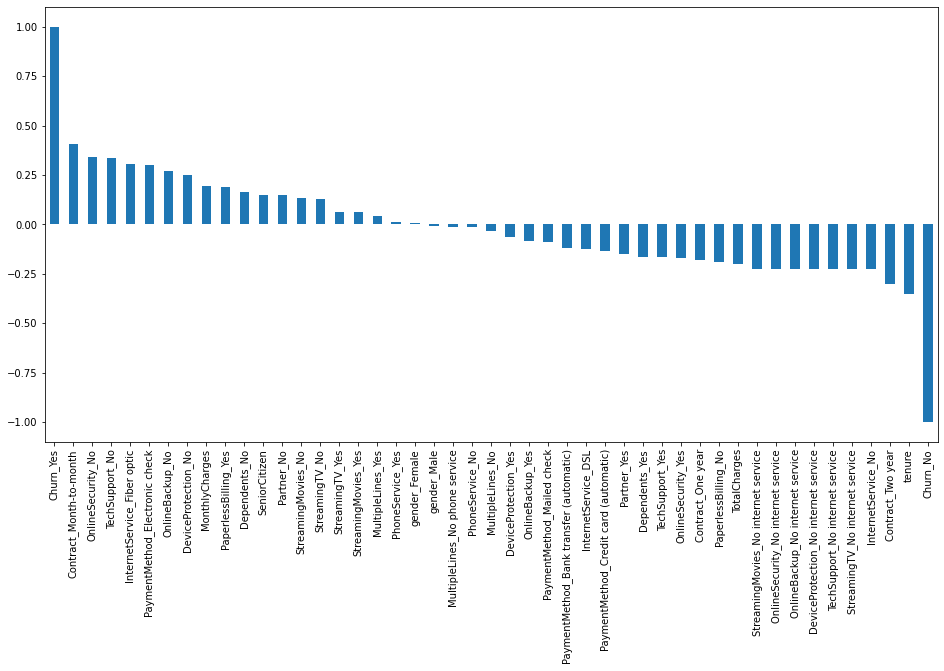

In [0]:
#Correlation of Churn with other variables:
plt.figure(figsize=(16,8))
df_dummies.corr()['Churn_Yes'].sort_values(ascending = False).plot(kind='bar')

Month-to-month contract, No online security, and NO tech support are positively correlated with Churn, while tenure and two-year contract are negatively correlated with Churn.


**Exploratory Data Analysis**

In [0]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


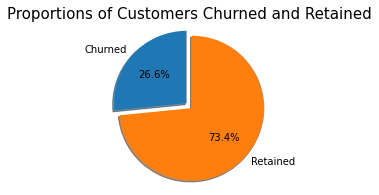

In [0]:
labels = 'Churned', 'Retained'
sizes = [df.Churn[df['Churn']=='Yes'].count(), df.Churn[df['Churn']=='No'].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(3, 3))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportions of Customers Churned and Retained", size = 15)
plt.show()

**Imbalanced dataset**



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ff19561d0>,
      dtype=object)

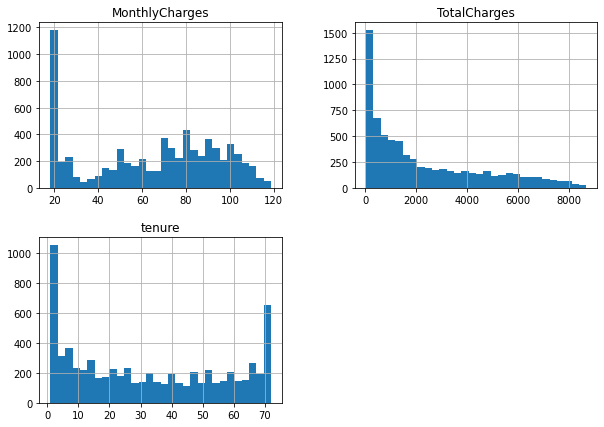

In [0]:
num_features.hist(bins=30, figsize=(10, 7))

Based on the above histograms, we can see that the monthly charges has a peak at 20 with the rest of the data points following a normal looking distribution with a mean of approximately 80. Total Charges has a peak at 0 with a distribution that trends down. There seems to be a large number of new customers and also a large number of customers whose been with the company for about 70 years.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2fef9ee080>,
      dtype=object)

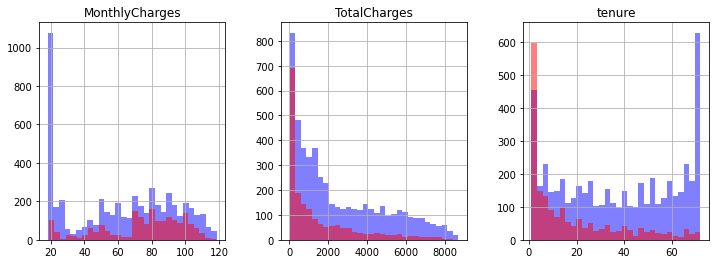

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df[df['Churn'] == "No"][['tenure','MonthlyCharges','TotalCharges']].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df['Churn'] == "Yes"][['tenure','MonthlyCharges','TotalCharges']].hist(bins=30, color="red", alpha=0.5, ax=ax)

Based on the above plots, we can see that Churn probability decreases as TotalCharges and tenure increases.

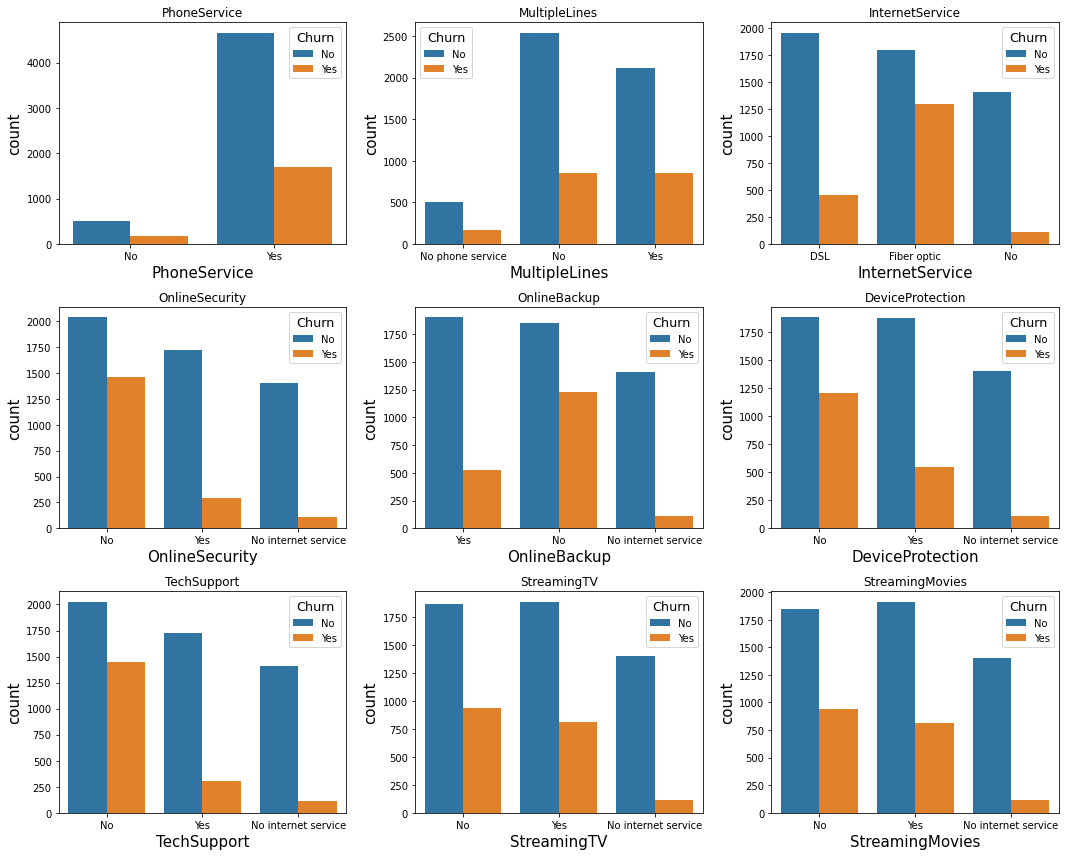

In [0]:
fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
sns.countplot(x='PhoneService', hue='Churn', data=df, ax=axes[0,0]).set_title('PhoneService')
sns.countplot(x='MultipleLines', hue='Churn', data=df, ax=axes[0,1]).set_title('MultipleLines')
sns.countplot(x='InternetService', hue='Churn', data=df, ax=axes[0,2]).set_title('InternetService')
sns.countplot(x='OnlineSecurity', hue='Churn', data=df, ax=axes[1,0]).set_title('OnlineSecurity')
sns.countplot(x='OnlineBackup', hue='Churn', data=df, ax=axes[1,1]).set_title('OnlineBackup')
sns.countplot(x='DeviceProtection', hue='Churn', data=df, ax=axes[1,2]).set_title('DeviceProtection')
sns.countplot(x='TechSupport', hue='Churn', data=df, ax=axes[2,0]).set_title('TechSupport')
sns.countplot(x='StreamingTV', hue='Churn', data=df, ax=axes[2,1]).set_title('StreamingTV')
sns.countplot(x='StreamingMovies', hue='Churn', data=df, ax=axes[2,2]).set_title('StreamingMovies')
plt.tight_layout()

# from google.colab import files
# plt.savefig('categorical_features.jpg')
# files.download('categorical_features.jpg')

Text(0, 0.5, 'Churn')

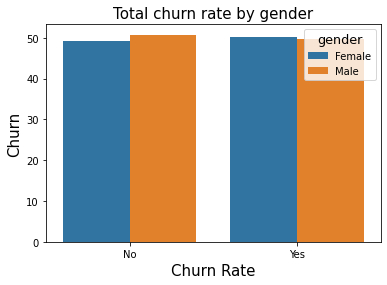

In [0]:
gender_churn_df=(df.groupby(['Churn','gender']).customerID.count() * 100/df.groupby(['Churn']).customerID.count()).reset_index()

ax=sns.barplot(x="Churn", y="customerID", hue="gender", data=gender_churn_df)
ax.axes.set_title("Total churn rate by gender", fontsize=15)
plt.xlabel('Churn Rate') #fontsize=20
plt.ylabel('Churn') #fontsize=20

# ax.legend(fontsize=15)
# for tick in ax.axes.xaxis.get_major_ticks():
#     tick.label.set_fontsize(15)

# for tick in ax.axes.yaxis.get_major_ticks():
#     tick.label.set_fontsize(15)